In [232]:
%pip install pandas numpy matplotlib scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, random, time


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Provide sensor data recording to run the processing/analysis on

In [233]:
import config
from importlib import reload
reload(config)
from config import *

### Cut off debug data from flashing if there's any left

In [234]:
HEADERS = "time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z"
lines = []
cutting = False
with open(SENSOR_DATA, 'r') as file:
    found_start = False
    for (i, line) in enumerate(file.readlines()):
        if not found_start and HEADERS in line:
            if i == 0:
                break
            found_start = True
            cutting = True
        if found_start:
            lines.append(line)
if cutting:
    with open(SENSOR_DATA, 'w') as file:
        file.writelines(lines[:-1])

### Run the sensor processing code

In [235]:
result = os.system(f'cargo run --release -- {SENSOR_DATA}')
if result != 0:
    raise Exception('Failed to compile sensor data')

    Finished `release` profile [optimized] target(s) in 0.03s
     Running `target/release/test-processing recordings/bling2.csv`
[2024-12-13T16:14:35Z ERROR lib_processing::step_detection] Reset because of step timeout


### Load sensor data

In [236]:
data = pd.read_csv(SENSOR_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
now = time.time()
data['t'] = pd.to_datetime((data['time'] / 1_000_000_000.0) + now, unit='s')
data.set_index(data['t'], inplace=True)
data.drop(columns=['t'], inplace=True)
data

,time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z
t,,,,,,,
2024-12-13 16:14:36.333277702,775198000,-0.005853,-0.021285,0.258075,-1.015141,-2.207454,9.423578
2024-12-13 16:14:36.344314814,786235000,-0.000532,-0.022881,0.241579,-0.653617,-2.348712,9.464279
2024-12-13 16:14:36.355049610,796970000,0.010642,-0.015963,0.123450,-0.620098,-2.224213,9.569624
2024-12-13 16:14:36.365873814,807794000,0.009578,-0.019688,0.075560,-0.555455,-2.442086,9.753978
2024-12-13 16:14:36.374659777,816580000,0.019156,-0.029266,0.001596,-0.725443,-2.183512,9.641450
...,...,...,...,...,...,...,...
2024-12-13 16:17:18.800218821,163242139000,-0.284148,-0.975363,0.562975,-0.548272,8.743625,4.757279
2024-12-13 16:17:18.809593678,163251514000,-0.251689,-0.893417,0.566168,-0.119710,8.511387,4.762067
2024-12-13 16:17:18.818961620,163260882000,-0.204863,-0.800298,0.562975,0.119710,8.425196,4.766856


### Load algorithm debug data

In [237]:
algo = pd.read_csv(ALGORITHM_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
algo['t'] = pd.to_datetime((algo['time'] / 1_000_000_000.0) + now, unit='s')
algo.set_index(algo['t'], inplace=True)
algo.drop(columns=['t'], inplace=True)

### Preview raw sensor data

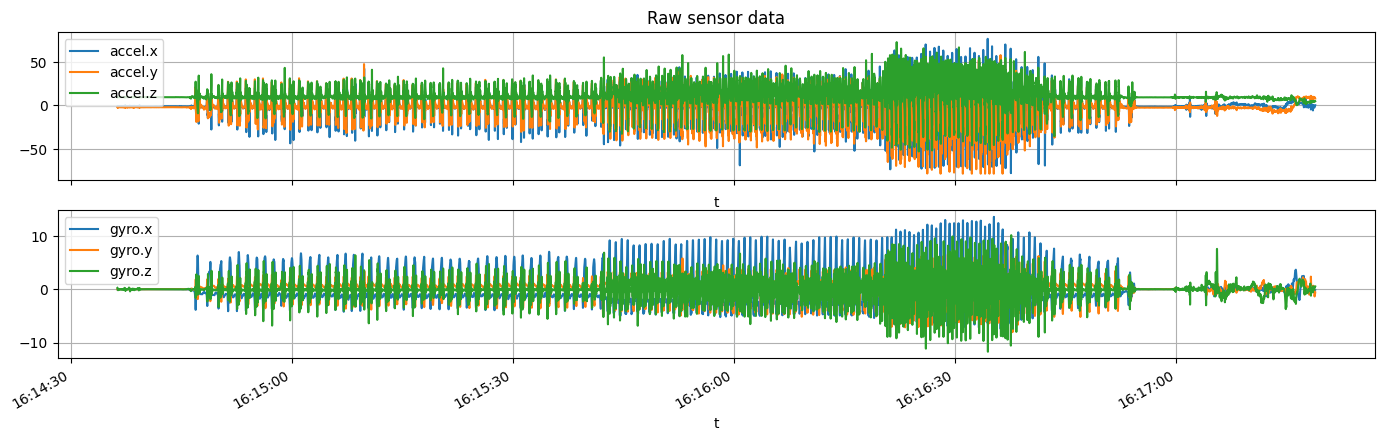

In [238]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['accel.x'].plot(ax=ax1)
data['accel.y'].plot(ax=ax1)
data['accel.z'].plot(ax=ax1)
ax1.xaxis.set_ticklabels([])
ax1.legend(loc='upper left')
ax1.grid()

data['gyro.x'].plot(ax=ax2)
data['gyro.y'].plot(ax=ax2)
data['gyro.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()

ax1.set_title('Raw sensor data')
fig.set_figwidth(17)

### Gravity vector length

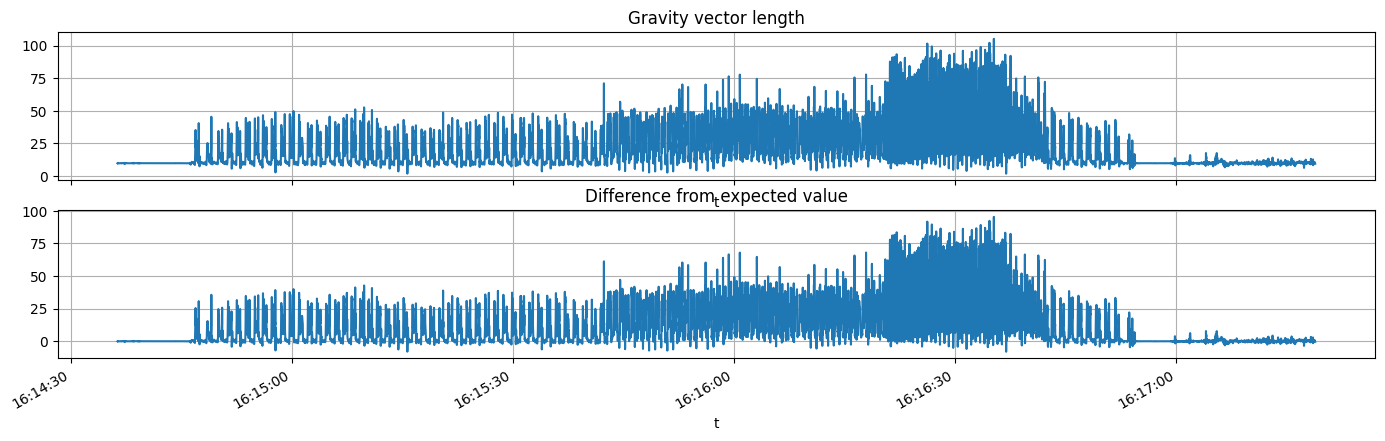

In [239]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['accel._length'] = np.sqrt(data['accel.x'] ** 2 + data['accel.y'] ** 2 + data['accel.z'] ** 2)
data['accel._length'].plot(ax=ax1)
ax1.grid()
ax1.set_title('Gravity vector length')
ax1.xaxis.set_ticklabels([])

data['gravity_delta'] = data['accel._length'] - 9.80665
data['gravity_delta'].plot(ax=ax2)
ax2.grid()
ax2.set_title('Difference from expected value')

fig.set_figwidth(17)

### Preview computed position, velocity, acceleration

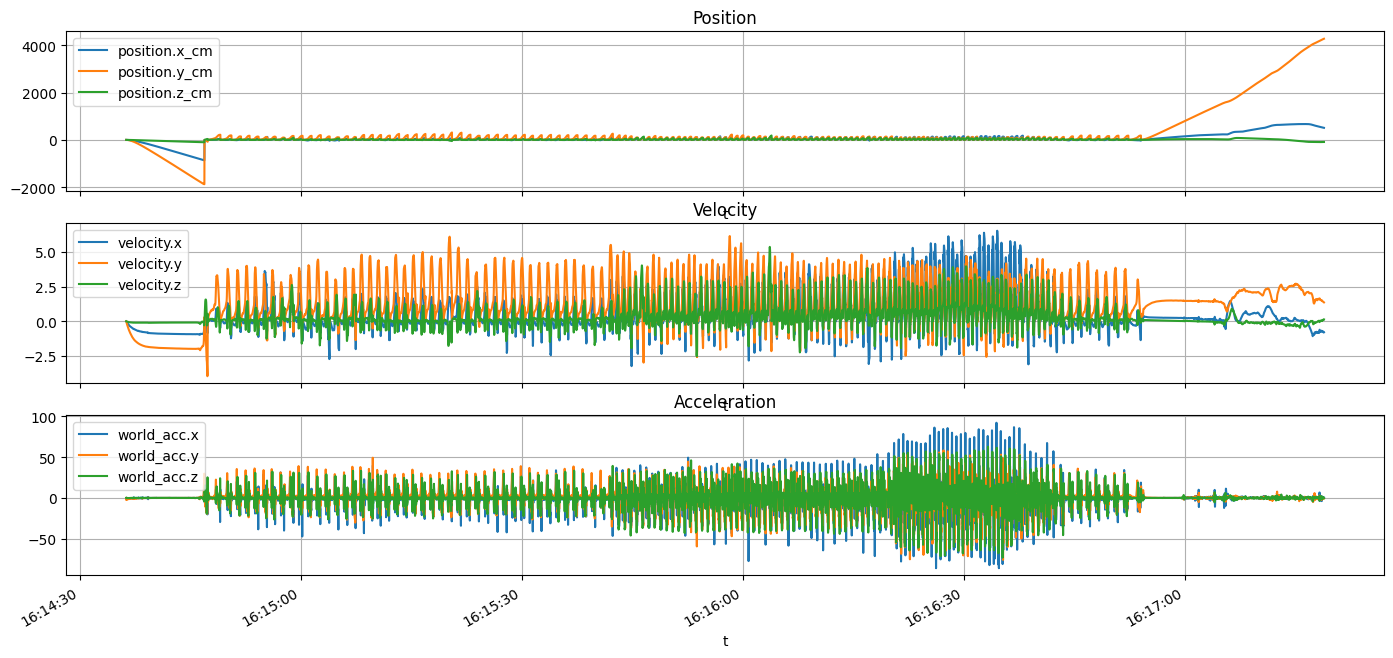

In [240]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

algo['position.x_cm'] = algo['position.x'] * 100
algo['position.y_cm'] = algo['position.y'] * 100
algo['position.z_cm'] = algo['position.z'] * 100

algo['position.x_cm'].plot(ax=ax1)
algo['position.y_cm'].plot(ax=ax1)
algo['position.z_cm'].plot(ax=ax1)
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Position')
ax1.xaxis.set_ticklabels([])

algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Velocity')
ax2.xaxis.set_ticklabels([])

algo['world_acc.x'].plot(ax=ax3)
algo['world_acc.y'].plot(ax=ax3)
algo['world_acc.z'].plot(ax=ax3)
ax3.legend(loc='upper left')

ax3.grid()
ax3.set_title('Acceleration')

fig.set_figwidth(17)
fig.set_figheight(8)

### Load Euler angles

In [241]:
angles = pd.read_csv(ANGLES_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
angles['t'] = pd.to_datetime((angles['time'] / 1_000_000_000.0) + now, unit='s')
angles.set_index(angles['t'], inplace=True)
angles.drop(columns=['t'], inplace=True)
angles.head()

,time,fusion.yaw,fusion.pitch,fusion.roll,gyro.yaw,gyro.pitch,gyro.roll,accel.yaw,accel.pitch,accel.roll,gyro.x,gyro.y,gyro.z,gyro.w
t,,,,,,,,,,,,,,
2024-12-13 16:14:36.333277702,775198016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-12-13 16:14:36.344314814,786235008,0.155875,0.023923,-0.139264,0.152768,-0.014469,-0.000356,5.348059e-08,3.834702,-13.937298,-0.000003,-0.000126,0.001333,0.999999
2024-12-13 16:14:36.355049610,796969984,0.233543,0.050288,-0.261807,0.228698,-0.024291,0.006164,2.673352e-08,3.611501,-13.084611,0.000054,-0.000212,0.001996,0.999998
2024-12-13 16:14:36.365873814,807793984,0.281389,0.069635,-0.393381,0.275556,-0.036509,0.012079,2.672110e-08,3.161889,-14.056107,0.000106,-0.000318,0.002405,0.999997
2024-12-13 16:14:36.374659777,816579968,0.283907,0.096388,-0.507085,0.276355,-0.051242,0.021722,0.000000e+00,4.197058,-12.760604,0.000191,-0.000447,0.002412,0.999997


### Compare orientations

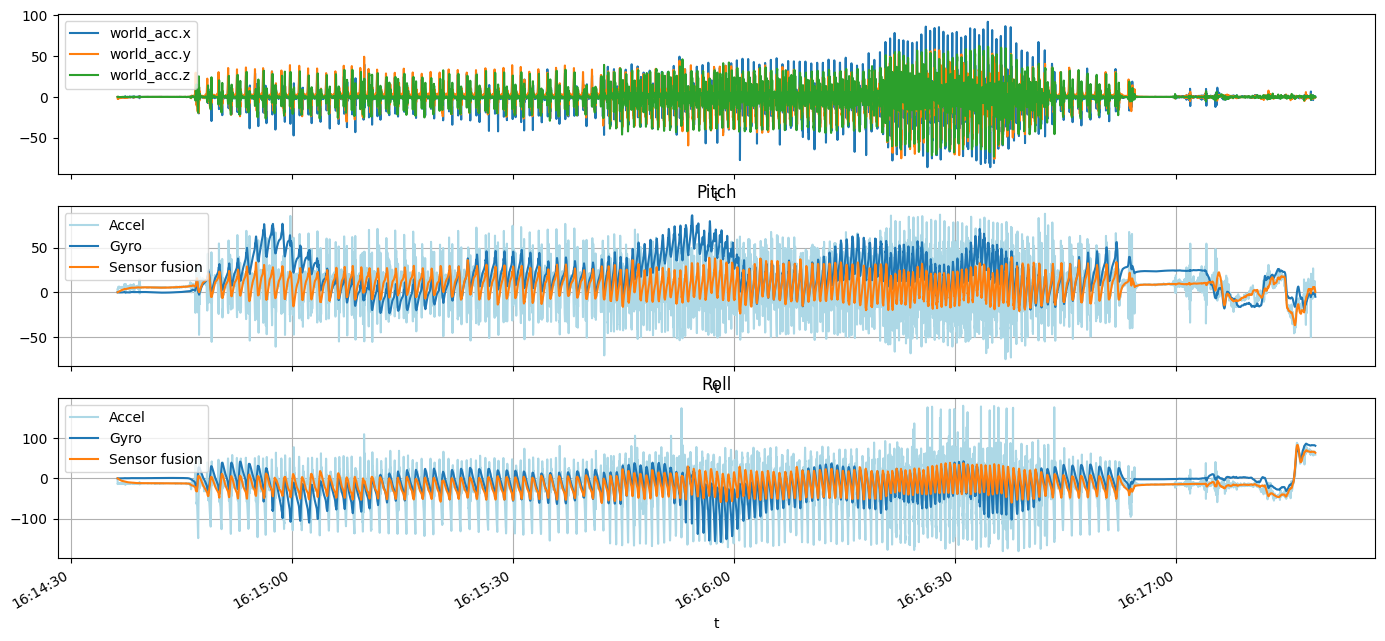

In [242]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# angles['accel.yaw'].plot(ax=ax1, label='Accel', color='lightblue')
# angles['gyro.yaw'].plot(ax=ax1, label='Gyro')
# angles['fusion.yaw'].plot(ax=ax1, label='Sensor fusion')
# ax1.legend(loc='upper left')
# ax1.grid()
# ax1.set_title('Yaw')
ax1.xaxis.set_ticklabels([])

angles['accel.pitch'].plot(ax=ax2, label='Accel', color='lightblue')
angles['gyro.pitch'].plot(ax=ax2, label='Gyro')
angles['fusion.pitch'].plot(ax=ax2, label='Sensor fusion')
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Pitch')
ax2.xaxis.set_ticklabels([])

angles['accel.roll'].plot(ax=ax3, label='Accel', color='lightblue')
angles['gyro.roll'].plot(ax=ax3, label='Gyro')
angles['fusion.roll'].plot(ax=ax3, label='Sensor fusion')
ax3.legend(loc='upper left')
ax3.grid()
ax3.set_title('Roll')

ax3 = ax1
algo['world_acc.x'].plot(ax=ax3)
algo['world_acc.y'].plot(ax=ax3)
algo['world_acc.z'].plot(ax=ax3)
ax3.legend(loc='upper left')


fig.set_figwidth(17)
fig.set_figheight(8)

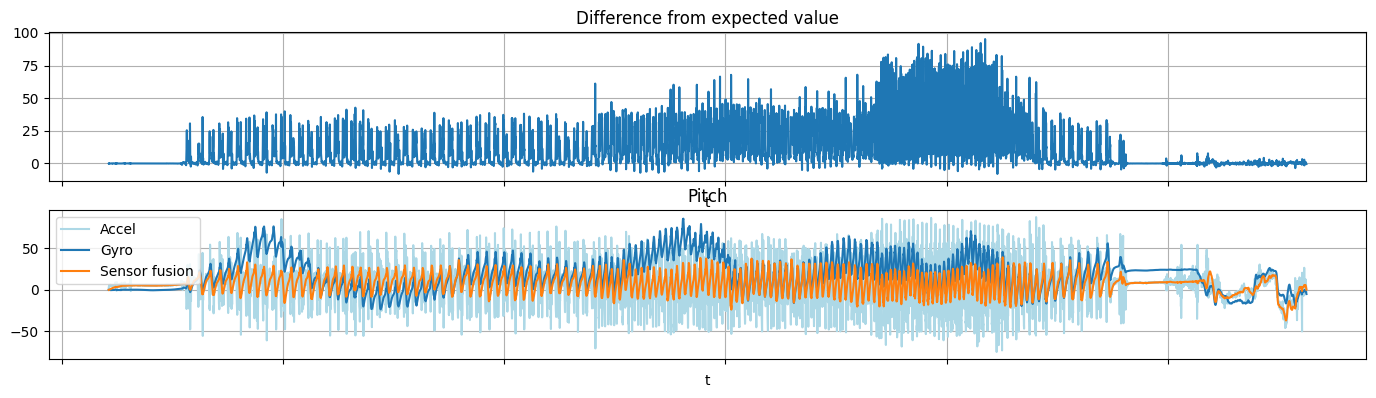

In [243]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['gravity_delta'].plot(ax=ax1)
ax1.set_title('Difference from expected value')
ax1.grid()
ax1.xaxis.set_ticklabels([])

angles['accel.pitch'].plot(ax=ax2, label='Accel', color='lightblue')
angles['gyro.pitch'].plot(ax=ax2, label='Gyro')
angles['fusion.pitch'].plot(ax=ax2, label='Sensor fusion')
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Pitch')
ax2.xaxis.set_ticklabels([])

fig.set_figwidth(17)

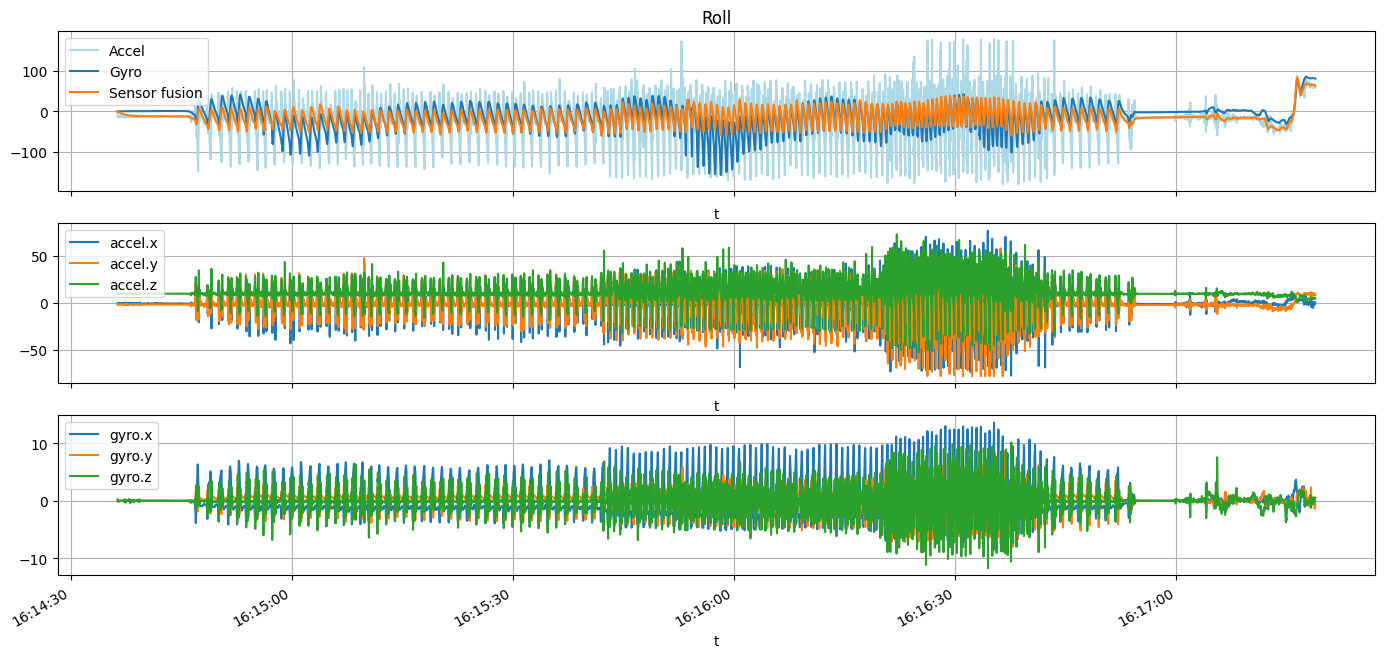

In [244]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

angles['accel.roll'].plot(ax=ax1, label='Accel', color='lightblue')
angles['gyro.roll'].plot(ax=ax1, label='Gyro')
angles['fusion.roll'].plot(ax=ax1, label='Sensor fusion')
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Roll')
ax1.xaxis.set_ticklabels([])

data['accel.x'].plot(ax=ax2)
data['accel.y'].plot(ax=ax2)
data['accel.z'].plot(ax=ax2)
ax2.xaxis.set_ticklabels([])
ax2.legend(loc='upper left')
ax2.grid()

data['gyro.x'].plot(ax=ax3)
data['gyro.y'].plot(ax=ax3)
data['gyro.z'].plot(ax=ax3)
ax3.legend(loc='upper left')
ax3.grid()

fig.set_figwidth(17)
fig.set_figheight(8)

In [245]:
steps = pd.read_csv(STEPS_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
steps['start'] = pd.to_datetime((steps['start'] / 1_000_000_000.0) + now, unit='s')
steps['peak'] = pd.to_datetime((steps['peak'] / 1_000_000_000.0) + now, unit='s')
steps['finished'] = pd.to_datetime((steps['finished'] / 1_000_000_000.0) + now, unit='s')
steps

,start,peak,finished,peak.x,peak.y,peak.z,velocity.x,velocity.y,velocity.z
0,2024-12-13 16:14:46.901748896,2024-12-13 16:14:35.558079720,2024-12-13 16:14:46.928226471,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-12-13 16:14:46.945137978,2024-12-13 16:14:47.269931316,2024-12-13 16:14:47.364292860,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-12-13 16:14:48.498674870,2024-12-13 16:14:48.930534601,2024-12-13 16:14:49.094440222,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-12-13 16:14:50.003858566,2024-12-13 16:14:50.397358418,2024-12-13 16:14:50.596152544,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-12-13 16:14:51.302734137,2024-12-13 16:14:51.692181826,2024-12-13 16:14:51.891851425,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
134,2024-12-13 16:16:47.840152740,2024-12-13 16:16:48.220359802,2024-12-13 16:16:48.364809513,NaN,NaN,NaN,NaN,NaN,NaN
135,2024-12-13 16:16:49.070943356,2024-12-13 16:16:49.680346251,2024-12-13 16:16:49.680346251,NaN,NaN,NaN,NaN,NaN,NaN
136,2024-12-13 16:16:50.356276512,2024-12-13 16:16:50.736303329,2024-12-13 16:16:50.946051359,NaN,NaN,NaN,NaN,NaN,NaN
137,2024-12-13 16:16:51.690851450,2024-12-13 16:16:52.082707644,2024-12-13 16:16:52.286229849,NaN,NaN,NaN,NaN,NaN,NaN


## Acceleration vector length

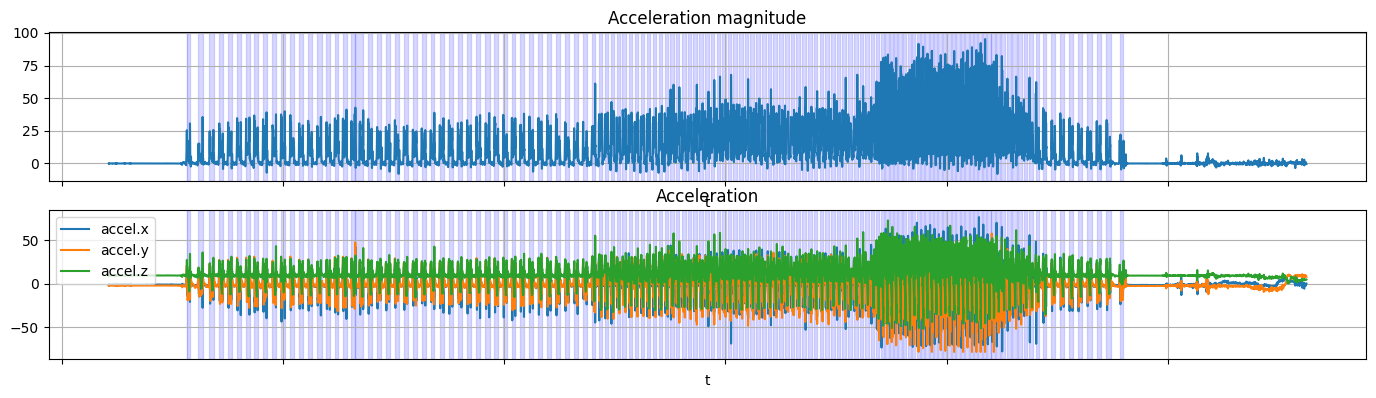

In [246]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['accel.length'] = np.sqrt(
    data['accel.x'] ** 2 + data['accel.y'] ** 2 + data['accel.z'] ** 2
) - 9.8

data['accel.length'].plot(ax=ax1)
ax1.set_title('Acceleration magnitude')
ax1.grid()
ax1.xaxis.set_ticklabels([])

data['accel.x'].plot(ax=ax2)
data['accel.y'].plot(ax=ax2)
data['accel.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Acceleration')
ax2.xaxis.set_ticklabels([])

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )
        
fig.set_figwidth(17)

## Velocity vector length

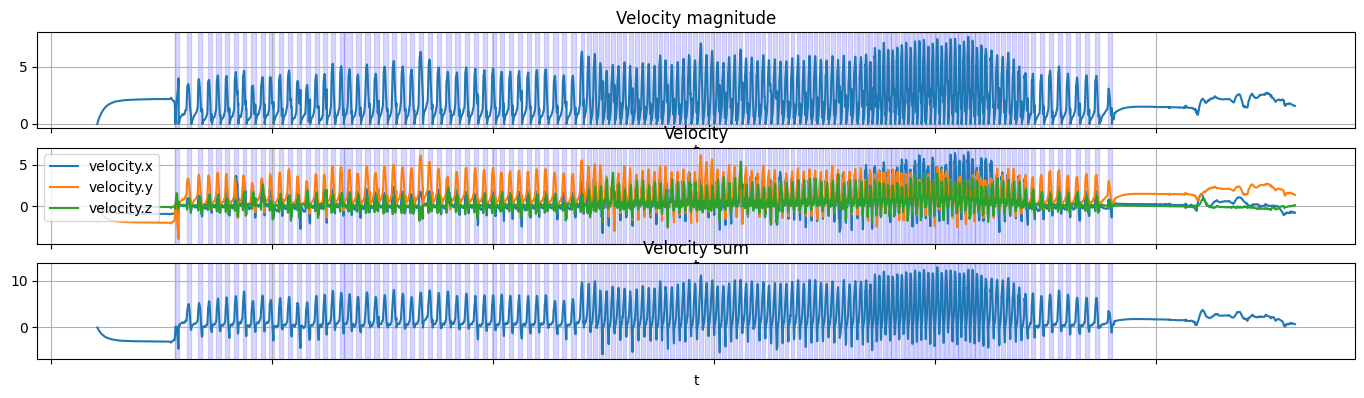

In [247]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

algo['velocity.length'] = np.sqrt(algo['velocity.x'] ** 2 + algo['velocity.y'] ** 2 + algo['velocity.z'] ** 2)
algo['velocity.sum'] = algo['velocity.x'] + algo['velocity.y'] + algo['velocity.z']

algo['velocity.length'].plot(ax=ax1)
ax1.set_title('Velocity magnitude')
ax1.grid()
ax1.xaxis.set_ticklabels([])


algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Velocity')
ax2.xaxis.set_ticklabels([])

algo['velocity.sum'].plot(ax=ax3)
ax3.set_title('Velocity sum')
ax3.grid()
ax3.xaxis.set_ticklabels([])

for ax in [ax1, ax2, ax3]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )
        
fig.set_figwidth(17)